In [1]:
# 1.Завантажити текстові дані та сформувати корпус текстів
import pandas as pd

data = pd.read_csv("Combined Data.csv")
print(data.head())
# корпус текстів
corpus = data['statement'].astype(str).tolist()
# розмір корпусу
print(f"Кількість текстів у корпусі: {len(corpus)}")

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1         137                               I'm so nervous, why?  Anxiety
2         138  but my heart is still restless even though my ...  Anxiety
3         139  Since then I was restless to the point of chok...  Anxiety
4         140  Starting to worry again if you have a lot of s...  Anxiety
Кількість текстів у корпусі: 12085


In [3]:
# 2. Здійснити препроцесінг тесту 
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
   # нормалізація
    text = text.lower()

    # видалення пунктуації та цифр
    text = re.sub(r'[^a-z\s]', ' ', text)

    # токенізація
    tokens = nltk.word_tokenize(text)

    # фільтрація(тільки слова і не стоп-слова)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # лематизація
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # стемінг 
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

# Застосування препроцесінгу до всього корпусу
processed_corpus = [preprocess_text(text) for text in corpus]

for i, processed in enumerate(processed_corpus[:3]):
    print(f"Оригінал: {corpus[i]}")
    print(f"Після препроцесінгу: {processed}\n")

# * прибрати не часто вживані слова або несуттєві для подальших операцій
from collections import Counter

# Частота слів
word_freq = Counter(word for doc in processed_corpus for word in doc)

# Фільтрація
processed_corpus = [
    [word for word in doc if word_freq[word] >= 3]
    for doc in processed_corpus
]

for i, processed in enumerate(processed_corpus[:3]):
    print(f"Оригінал: {corpus[i]}")
    print(f"Після препроцесінгу: {processed}\n")

Оригінал: oh my gosh
Після препроцесінгу: ['oh', 'gosh']

Оригінал: I'm so nervous, why?
Після препроцесінгу: ['nervou']

Оригінал: but my heart is still restless even though my mouth is talking
Після препроцесінгу: ['heart', 'still', 'restless', 'even', 'though', 'mouth', 'talk']

Оригінал: oh my gosh
Після препроцесінгу: ['oh', 'gosh']

Оригінал: I'm so nervous, why?
Після препроцесінгу: ['nervou']

Оригінал: but my heart is still restless even though my mouth is talking
Після препроцесінгу: ['heart', 'still', 'restless', 'even', 'though', 'mouth', 'talk']



Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


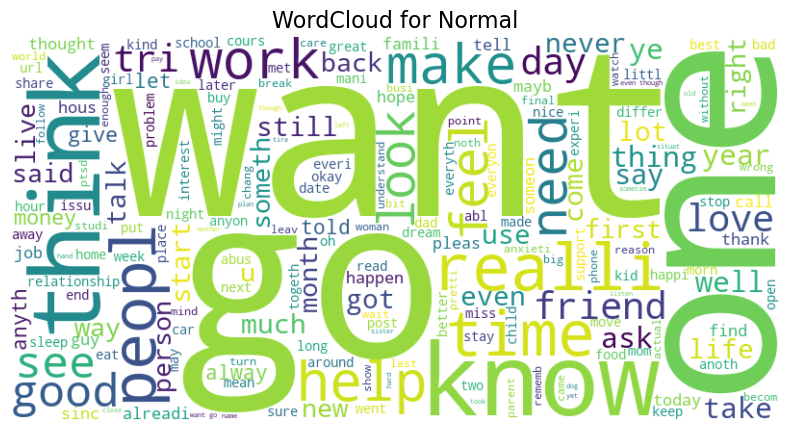

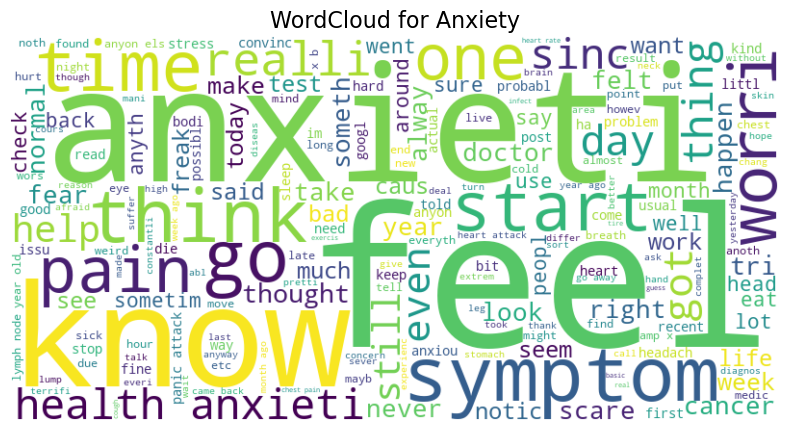

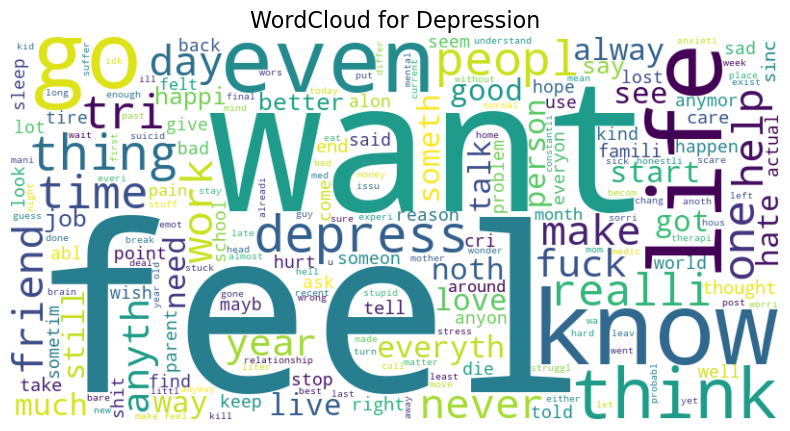

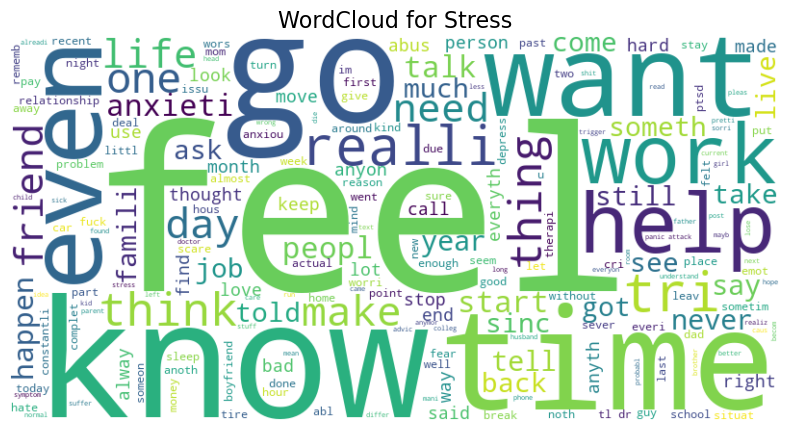

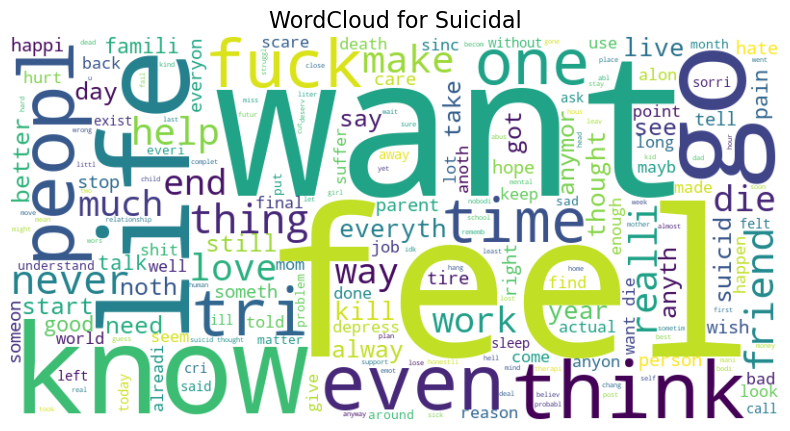

In [5]:
# 3. Візуалізувати найбільш та найменш часто вживані слова в межах кожного класу.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print(data.columns)
labels = ['Normal', 'Anxiety', 'Depression', 'Stress', 'Suicidal']

# Додаємо препроцесований текст як одну колонку
data['processed'] = [' '.join(doc) for doc in processed_corpus]

# Функція для побудови wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Генерація WordCloud для кожного класу
for label in labels:
    class_texts = data[data['status'] == label]['processed']
    combined_text = ' '.join(class_texts)
    generate_wordcloud(combined_text, f'WordCloud for {label}')

In [7]:
# 4.Створити зважену матрицю термінів та проаналізувати її. Сформувати мішки слів
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1. BoW — мішок слів
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(data['processed'])

print("BoW Shape:", bow_matrix.shape)  # (кількість документів, кількість унікальних слів)

# Перетворимо на датафрейм для аналізу
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
print("Найчастіші слова у BoW:")
print(bow_df.sum().sort_values(ascending=False).head(10))

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed'])

print("\nTF-IDF Shape:", tfidf_matrix.shape)
# Перетворимо на датафрейм для аналізу
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("Найбільш значущі слова (за середнім TF-IDF):")
print(tfidf_df.mean().sort_values(ascending=False).head(10))

BoW Shape: (12085, 6588)
Найчастіші слова у BoW:
feel     7143
like     6570
get      5123
go       4931
want     4737
know     4296
time     3794
life     3140
think    3125
day      3001
dtype: int64

TF-IDF Shape: (12085, 6588)
Найбільш значущі слова (за середнім TF-IDF):
like      0.030556
feel      0.030114
want      0.027463
go        0.027062
get       0.023682
know      0.022363
think     0.018709
realli    0.018143
time      0.018052
day       0.016015
dtype: float64


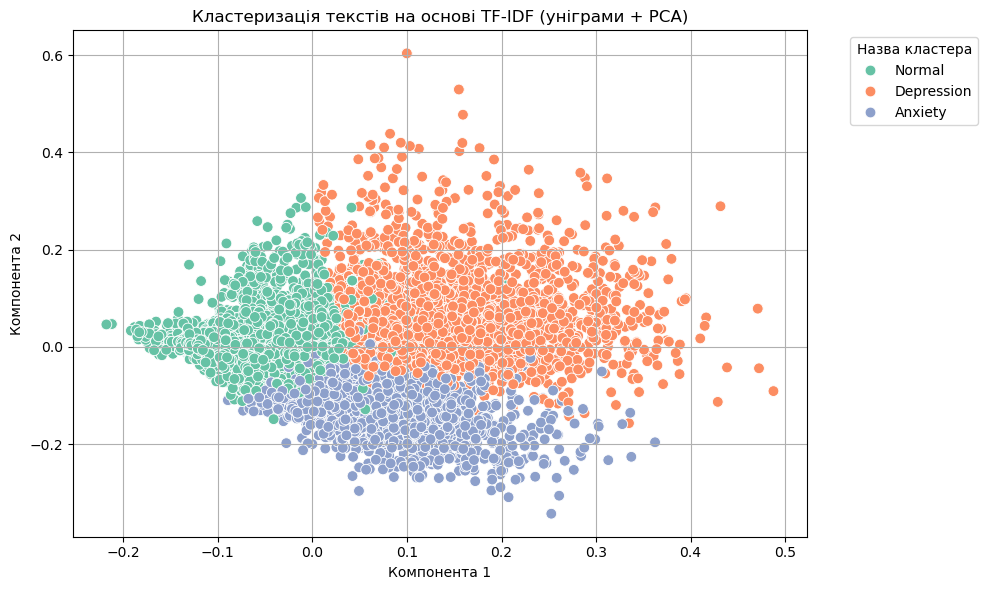

In [33]:
# 5. Побудувати кластеризацію на основі TF-IDF для встановлення подібності текстів
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)
data['cluster'] = clusters

# кластер - стан
cluster_to_label = (
    data.groupby('cluster')['status']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

data['cluster_name'] = data['cluster'].map(cluster_to_label)

# Зменшення розмірності до 2D для візуалізації
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())


plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],
                hue=data['cluster_name'], palette='Set2', s=60)
plt.title('Кластеризація текстів на основі TF-IDF (уніграми + PCA)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(title='Назва кластера', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

BoW Shape (біграми): (12085, 250119)
Найчастіші біграми:
feel like            2212
health anxieti       650
year old             409
panic attack         388
anyon els            349
get better           339
even though          324
year ago             316
want die             292
everi day            290
TF-IDF Shape (біграми): (12085, 50000)
Найбільш значущі біграми (за середнім TF-IDF):
feel like         0.010962
health anxieti    0.004080
even though       0.003044
anyon els         0.003015
everi day         0.002926
year old          0.002864
want go           0.002838
want die          0.002660
panic attack      0.002637
get better        0.002628
dtype: float64


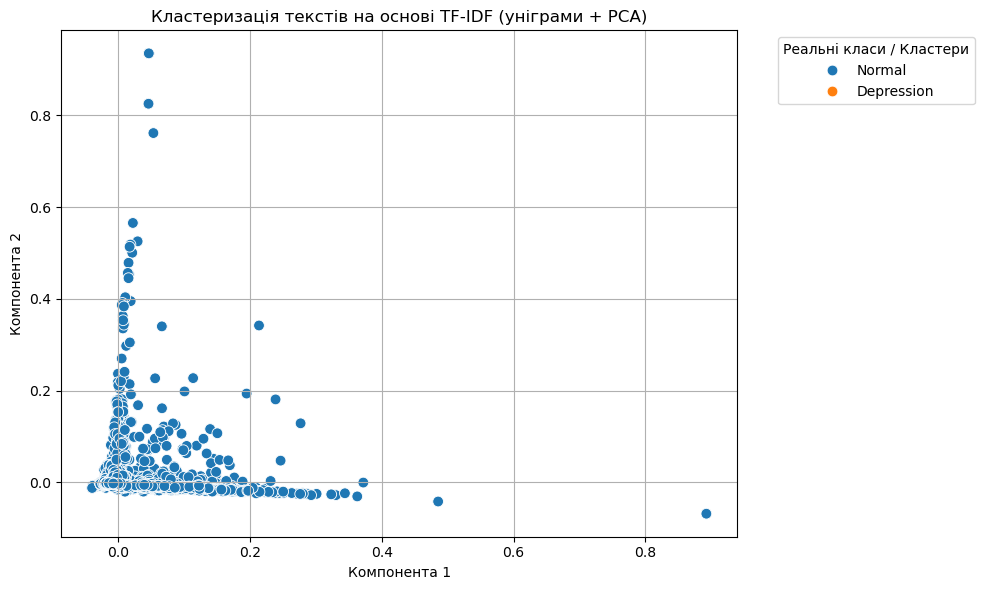

In [35]:
#6. Повторити попередні етапи для суміші n-грам та порівняти отримані результати
import numpy as np

# Мішок слів із біграмами
bow_vectorizer_ngram = CountVectorizer(ngram_range=(2, 2))  # (1,1) - уніграми, (2,2) - біграми, (1,2) - уніграми+біграми
bow_matrix_ngram = bow_vectorizer_ngram.fit_transform(data['processed'])

print("BoW Shape (біграми):", bow_matrix_ngram.shape)

# Аналіз найбільш частих біграм
bow_sum = np.array(bow_matrix_ngram.sum(axis=0)).flatten()
features = bow_vectorizer_ngram.get_feature_names_out()
top_bow = sorted(zip(features, bow_sum), key=lambda x: x[1], reverse=True)[:10]

print("Найчастіші біграми:")
for bigram, count in top_bow:
    print(f"{bigram:20} {count}")

#побудова TF-IDF з біграмами
tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range=(2, 2), max_features=50000) 
tfidf_matrix_ngram = tfidf_vectorizer_ngram.fit_transform(data['processed'])

print("TF-IDF Shape (біграми):", tfidf_matrix_ngram.shape)

# Аналіз найбільш значущих біграм за середнім TF-IDF
means = np.asarray(tfidf_matrix_ngram.mean(axis=0)).flatten()
features = tfidf_vectorizer_ngram.get_feature_names_out()
top_tfidf = pd.Series(means, index=features).sort_values(ascending=False).head(10)

print("Найбільш значущі біграми (за середнім TF-IDF):")
print(top_tfidf)

# Кластеризація
kmeans_ngram = KMeans(n_clusters=5, random_state=42)
clusters_ngram = kmeans_ngram.fit_predict(tfidf_matrix_ngram)

data['cluster_ngram'] = clusters_ngram

cluster_to_label = (
    data.groupby('cluster_ngram')['status']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

data['cluster_name'] = data['cluster_ngram'].map(cluster_to_label)


pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix_ngram.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],
                hue=data['cluster_name'], palette='tab10', s=60)
plt.title('Кластеризація текстів на основі TF-IDF (уніграми + PCA)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(title='Реальні класи / Кластери', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

=== Logistic Regression ===
Accuracy: 0.7960281340504758
              precision    recall  f1-score   support

     Anxiety       0.90      0.88      0.89       386
  Depression       0.67      0.54      0.59       340
      Normal       0.83      0.97      0.89      1212
      Stress       0.69      0.29      0.41       194
    Suicidal       0.64      0.59      0.61       285

    accuracy                           0.80      2417
   macro avg       0.74      0.65      0.68      2417
weighted avg       0.78      0.80      0.78      2417



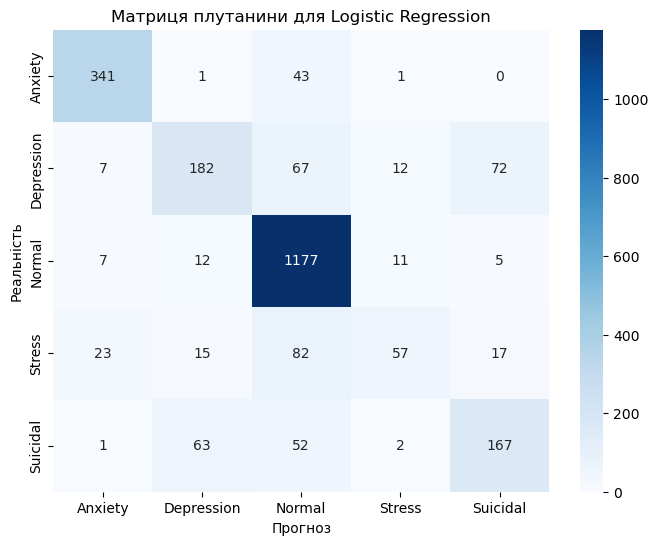

Accuracy: 0.7571369466280513
              precision    recall  f1-score   support

     Anxiety       0.81      0.85      0.83       386
  Depression       0.63      0.52      0.57       340
      Normal       0.78      0.98      0.87      1212
      Stress       0.80      0.06      0.11       194
    Suicidal       0.64      0.42      0.51       285

    accuracy                           0.76      2417
   macro avg       0.73      0.57      0.58      2417
weighted avg       0.75      0.76      0.72      2417



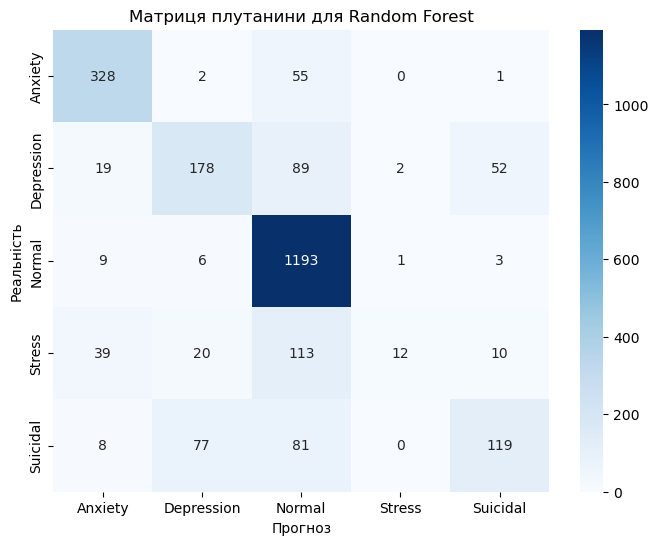

In [51]:
# 17.1 На основі даних з попередньої роботи та 2-х відомих вам алгоритмів побудувати класифікатор текстів.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['status'])
X = tfidf_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_log)

# Додаємо назви класів (тобто status'и)
class_names = label_encoder.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Прогноз')
plt.ylabel('Реальність')
plt.title('Матриця плутанини для Logistic Regression')
plt.show()

#Random Forest Tree
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Додаємо назви класів (тобто status'и)
class_names = label_encoder.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Прогноз')
plt.ylabel('Реальність')
plt.title('Матриця плутанини для Random Forest')
plt.show()

In [53]:
# 17.2 Провести підбір оптимальних параметрів (параметрів самого алгоритму та самого тексту, як вхідних даних)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.75, 0.85, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__max_features': [None, 5000, 10000],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(data['processed'], y)

# Вивід результатів
print("Найкращі параметри:")
print(grid_search.best_params_)
print("Найкраща точність:")
print(grid_search.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


D:\Anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Найкращі параметри:
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Найкраща точність:
0.7918065105443332


In [59]:
# 17.3 Оцінити отримані моделі з застосуванням метрик (precision, recall, f1, support) та порівняти отримані результати. 
log_report = classification_report(
y_test, y_pred_log,
target_names=label_encoder.classes_,
output_dict=True,
zero_division=0
)
log_df = pd.DataFrame(log_report).transpose()


rf_report = classification_report(
y_test, y_pred,
target_names=label_encoder.classes_,
output_dict=True,
zero_division=0
)
rf_df = pd.DataFrame(rf_report).transpose()

print("=== Порівняння середніх метрик ===")
comparison = pd.DataFrame({
"Model": ["Logistic Regression", "Random Forest"],
"Accuracy": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred)],
"Precision": [log_df.loc["macro avg", "precision"], rf_df.loc["macro avg", "precision"]],
"Recall": [log_df.loc["macro avg", "recall"], rf_df.loc["macro avg", "recall"]],
"F1-score": [log_df.loc["macro avg", "f1-score"], rf_df.loc["macro avg", "f1-score"]],
})
print(comparison)

=== Порівняння середніх метрик ===
                 Model  Accuracy  Macro Avg Precision  Macro Avg Recall  \
0  Logistic Regression  0.796028             0.744257          0.653923   
1        Random Forest  0.757137             0.733069          0.567399   

   Macro Avg F1-score  
0            0.680523  
1            0.578785  
